In [1]:
import matplotlib.pyplot as plt
from matplotlib import ticker  # Import ticker from matplotlib
from matplotlib.ticker import MultipleLocator
from matplotlib.gridspec import GridSpec
import glob
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import seaborn as sns
import os
from sys import float_info
import scipy.constants as constants
from matplotlib.ticker import FormatStrFormatter
print('finished import')

finished import


C:\Users\au302163\AppData\Local\Temp\ipykernel_24644\1885033045.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios':[3,1]})


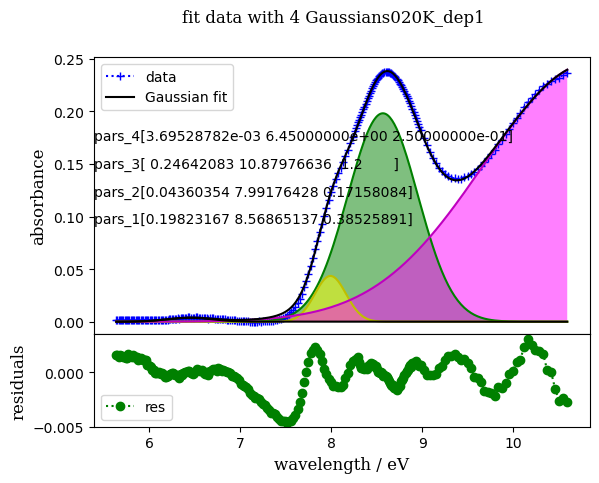

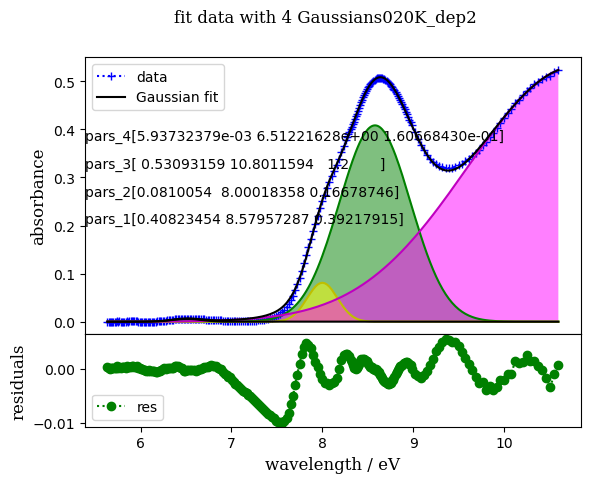

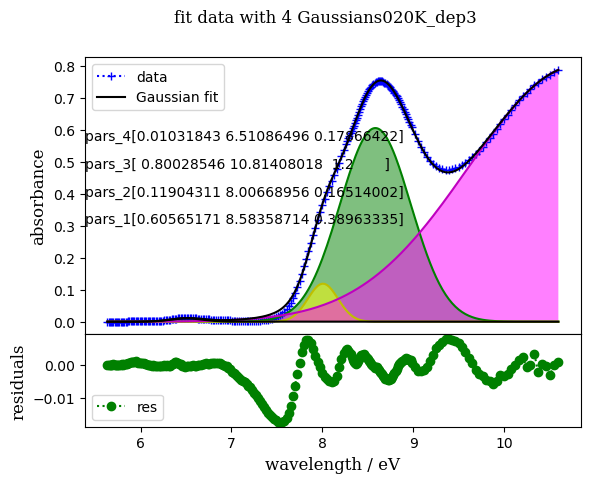

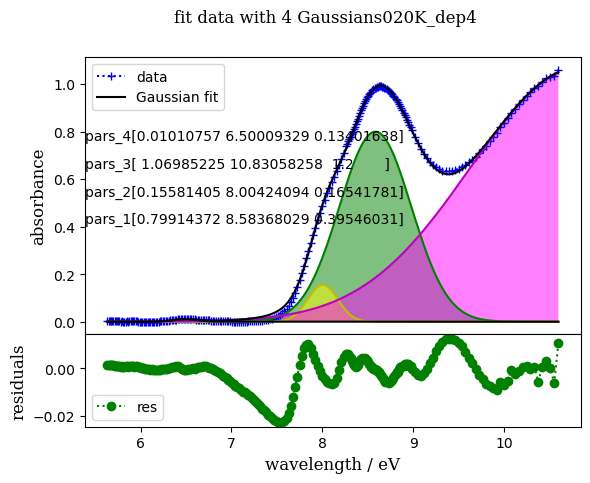

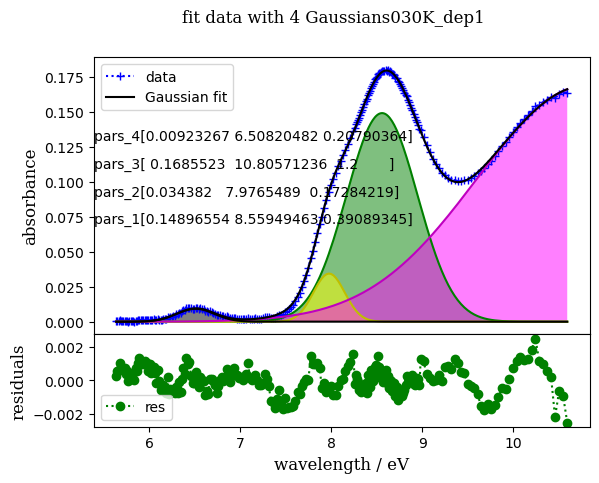

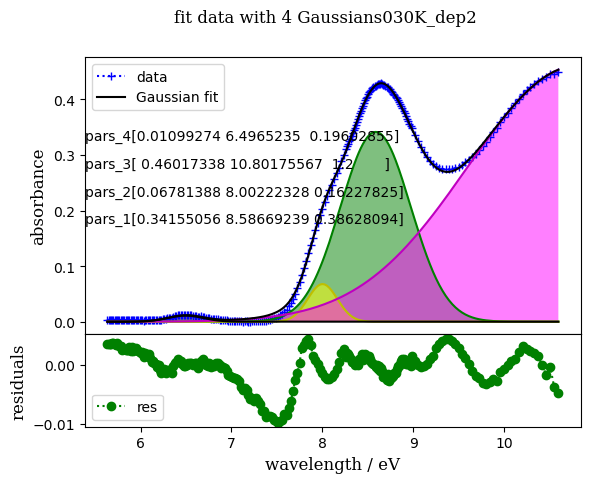

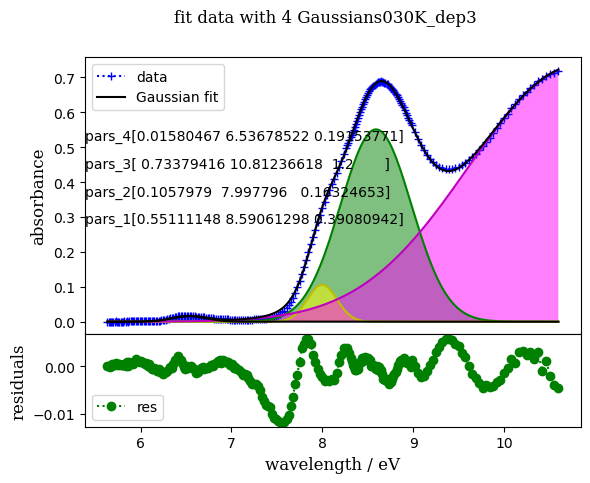

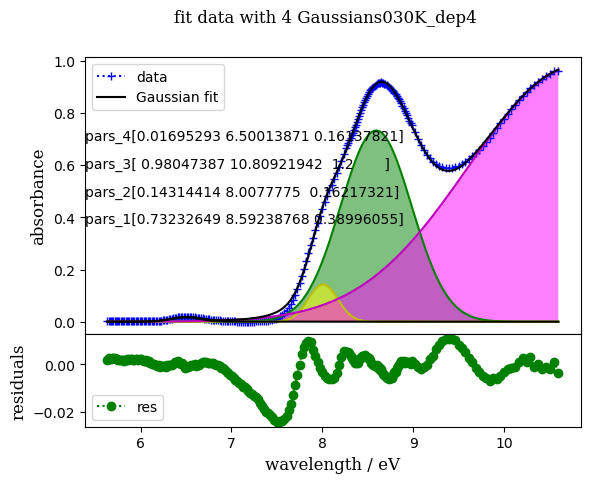

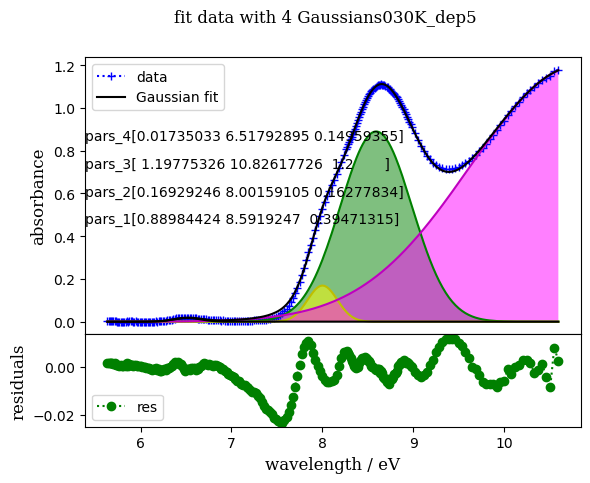

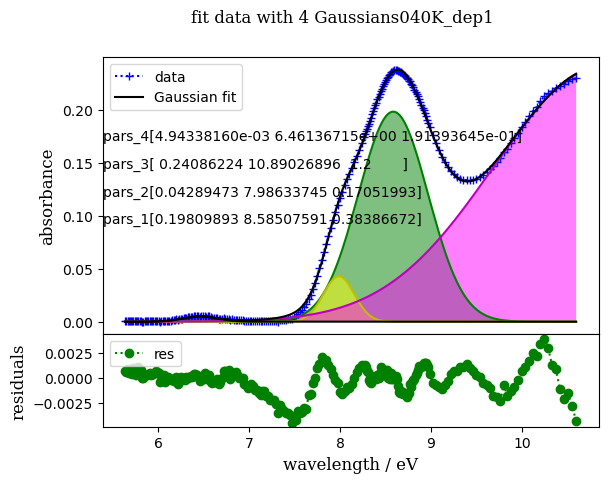

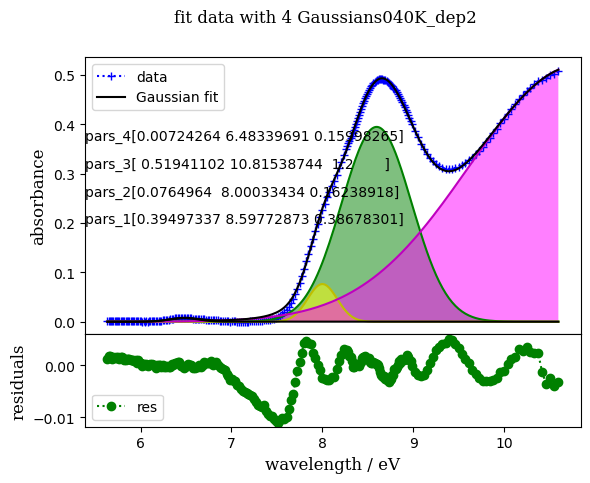

In [ ]:
# Find data files and fit all VUV spectra with Gaussians
#--------------------------------------------------------


path = 'processed'
export_path='exports'

# glob processed files
temperatures = glob.glob(path)
data_files = glob.glob('processed/***.txt')

# Funciton definitions
#--------------------------------------------------------

#   Gaussian formula
def gaussian(x, A, x0, sig):
    return A*np.exp(-(x-x0)**2/(2*sig**2))

def multi_gaussian(x, *pars):
    
    g1 = gaussian(x, pars[0], pars[1], pars[2])
    g2 = gaussian(x, pars[3], pars[4], pars[5])
    g3 = gaussian(x, pars[6], pars[7], pars[8])
    g4 = gaussian(x, pars[9], pars[10], pars[11])    
    return g1 + g2 + g3 + g4

# Converting wavelength (nm) to energy (eV)
# Function to prevent zero values in an array
def preventDivisionByZero(some_array):
    corrected_array = some_array.copy()
    for i, entry in enumerate(some_array):
        # If element is zero, set to some small value
        if abs(entry) < float_info.epsilon:
            corrected_array[i] = float_info.epsilon
    
    return corrected_array

def WLtoE(wl):
    # Prevent division by zero error
    wl = preventDivisionByZero(wl)

    # E = h*c/wl            
    h = constants.h         # Planck constant
    c = constants.c         # Speed of light
    J_eV = constants.e      # Joule-electronvolt relationship
    
    wl_nm = wl * 10**(-9)   # convert wl from nm to m
    E_J = (h*c) / wl_nm     # energy in units of J
    E_eV = E_J / J_eV       # energy in units of eV
    
    return E_eV  

# Converting energy (eV) to wavelength (nm)
def EtoWL(E):
    # Prevent division by zero error
    E = preventDivisionByZero(E)
    
    # Calculates the wavelength in nm
    return constants.h * constants.c / (constants.e * E) * 10**9

def PlotGaussFit(name, x, data, fit, residuals_4gauss, gauss_peak_1,gauss_peak_2,gauss_peak_3,gauss_peak_4):
    
    ###
    
    fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios':[3,1]})
    fig.subplots_adjust(hspace=0) # Remove horizontal space between axes

    fig.suptitle('fit data with 4 Gaussians'+name, family="serif", fontsize=12)
    plt.xlabel('wavelength / eV', family="serif", fontsize=12)

    axs[1].plot(x,residuals_4gauss,'go:',label='res')

    axs[1].set_ylabel("residuals",family="serif", fontsize=12)  
    axs[0].plot(x,data,'b+:',label='data')

    axs[0].plot(x, gauss_peak_1, "g")
    axs[0].fill_between(x, gauss_peak_1.min(), gauss_peak_1, facecolor="green", alpha=0.5)

    axs[0].set_ylabel("absorbance",family="serif", fontsize=12)    
    axs[0].plot(x,  gauss_peak_2, "y")
    axs[0].fill_between(x, gauss_peak_2.min(), gauss_peak_2, facecolor="yellow", alpha=0.5)  

    axs[0].plot(x,  gauss_peak_3, "m")
    axs[0].fill_between(x, gauss_peak_3.min(), gauss_peak_3, facecolor="magenta", alpha=0.5)  

    axs[0].plot(x,  gauss_peak_4, "k")
    axs[0].fill_between(x, gauss_peak_4.min(), gauss_peak_4, facecolor="k", alpha=0.5)  
    
    axs[0].plot(x,  fit, "-k", label = 'Gaussian fit')

    axs[0].annotate(residuals, xy =(150, max(df['absorbance_bk'])))
    axs[0].text(0,0.7,'pars_4'+str(pars_4),transform=axs[0].transAxes)
    axs[0].text(0,0.6,'pars_3'+str(pars_3),transform=axs[0].transAxes)
    axs[0].text(0,0.5,'pars_2'+str(pars_2),transform=axs[0].transAxes)
    axs[0].text(0,0.4,'pars_1'+str(pars_1),transform=axs[0].transAxes)

    axs[1].legend()
    axs[0].legend()

def gaussian_area(A, sig):
    return A * sig * np.sqrt(2 * np.pi)

#   initial guess with bounds for eV fit
init_vals = [0.2, 8.6,0.38,
         0.05, 8.4, 0.172,
         0.3, 10.830, 1.22,
         0.05, 6.5, 0.174]

bounds_min = [0.01,8.0,0.37, # 8 eV peak
              0.01,7.2,0.1, # 7 eV peak
              0,10.8,1.2, # high energy background peak
              0,6.45,0] # low energy peak

bounds_max = [1.2,8.9,0.4,
              0.4,8.5,0.3,
              1.3,10.9,1.23,
              0.05,6.55,0.25]

#   create lists for data, temp & deposition
data_dict=[]
temp = []
depo = []
deltas = []

#   Load files and fit
#--------------------------------------------------------

for i in data_files:
    
    #   find temperature from data file name
    temperature = int(i[16:19])
    
    #   adjust for file naming - i.e. add  0.5 K to 127.5 and 137.5 K
    temperature = np.where((temperature==127 or temperature==137) , temperature+0.5, temperature)
    
    #   load data in datafram
    df = pd.read_csv(i, delimiter=' ', names=['wavelength', 'absorbance'])
       
    #   find data file name
    name = i[16:-4]
    #   find deposition number from file name
    d = i.find('dep')
    deposition = int(i[d+3])

    #   discard data below 117 nm and above 220 nm
    df = df.drop(df[df['wavelength']<117].index)

    #   set a linear background by finding the minimum point on the curve and drawing a linear line here
    linear_BkGd=df['absorbance'].min()
    #   substract bkg
    y = df['absorbance_bk'] = df['absorbance'] - linear_BkGd  
    
    # #make shorthand for wavelength
    x = WLtoE(df['wavelength'])

    #   fit Gaussian
    popt, pcov = curve_fit(multi_gaussian, x, df['absorbance_bk'], p0=init_vals, bounds=(bounds_min,bounds_max))
    
    perr_3gauss = np.sqrt(np.diag(pcov))

    pars_1 = popt[0:3]
    pars_2 = popt[3:6]
    pars_3 = popt[6:9]
    pars_4 = popt[9:12]

    gauss_peak_1 = gaussian(x, *pars_1)
    gauss_peak_2 = gaussian(x, *pars_2)
    gauss_peak_3 = gaussian(x, *pars_3)
    gauss_peak_4 = gaussian(x, *pars_4)
    fit = gauss_peak_1 + gauss_peak_2 + gauss_peak_3 + gauss_peak_4
    
    #calculate errors and residuals:
    df['residual_3gauss']=residual_2gauss = y - (multi_gaussian(x, *popt))
    df['Gauss_1'] = gauss_peak_1
    df['Gauss_2'] = gauss_peak_2
    df['Gauss_3'] = gauss_peak_3
    df['Gauss_4'] = gauss_peak_4
    df['Gauss_fit'] = fit
    residuals=sum((df['absorbance_bk']-(multi_gaussian(df['wavelength'], *popt)))**2)

    #   fit parameters
    #---------------------
    pars_err_1 = perr_3gauss[0:3] # divide the output parameteres into to arrays, one for the first Gaussian; a 2nd for Gaussian 2; etc
    pars_err_2 = perr_3gauss[3:6]
    pars_err_3 = perr_3gauss[6:9]
    pars_err_4 = perr_3gauss[9:12]
    
    #   Concatenate fits
    Gauss = np.concatenate((pars_1, pars_err_1, pars_2, pars_err_2, pars_3, pars_err_3, pars_4, pars_err_4))

    #   Append Gaus, Temp and Dep to respective lists
    data_dict.append(Gauss)
    temp.append(temperature)
    depo.append(deposition)

    # plot each fit, file by file
    PlotGaussFit(name, x, df['absorbance_bk'], fit, df['residual_3gauss'], gauss_peak_1,gauss_peak_2,gauss_peak_3,gauss_peak_4)

    area1 = gaussian_area(popt[0], popt[3])
    #print("The area under the Gaussian curve 1 is:", area1)

    area2= gaussian_area(popt[4], popt[6])
    #print("The area under the Gaussian curve 2 is:", area2)

    #print("The ratio of A1 / A2 is:", area1/area2)
    
    # Save the dataframe to csv file
    
    df.to_csv('exports/'+name+'.csv', index=False)

#put all of the fit outcomes into a dataframe called "p"
data_dict = np.array(data_dict)
temp = np.array(temp)
depo = np.array(depo)
data = np.round(np.concatenate((temp[:,None], depo[:,None],data_dict), axis=1),8)
data_dict=dict(enumerate(data,0))

p = pd.DataFrame(data, columns=['temp','dep',
                                'ab1','peak1','sig1','ab1_err','peak1_err','sig1_err',
                                'ab2','peak2','sig2','ab2_err','peak2_err','sig2_err',
                                'ab3','peak3','sig3','ab3_err','peak3_err','sig3_err',
                                'ab4','peak4','sig4','ab4_err','peak4_err','sig4_err'])
p.to_csv('gaussian_fits.csv', index=False)

#    Plot fit outcomes and parameter space explored, if required
#--------------------------------------------------------

def PlotGauss_PeakMax(dataframe):
    fig, axs = plt.subplots(4, 1, sharex=True, figsize=(4,7)) # I am making a 4 x 1 row x column grid
    fig.subplots_adjust(hspace=0.1)
    plt.xlabel('temperature / K', family="garamond", fontsize=18)
    plt.rcParams['errorbar.capsize']=2
    dataframe.loc[(dataframe.ab1>0.40) & (dataframe.ab1<0.71)].plot.scatter(x='temp',y='peak1', yerr = 'peak1_err', ax=axs[1])
    dataframe.loc[(dataframe.ab1>0.40) & (dataframe.ab1<0.71)].plot.scatter(x='temp',y='peak2', yerr = 'peak2_err',ax=axs[2])
    dataframe.loc[(dataframe.ab1>0.40) & (dataframe.ab1<0.71)].plot.scatter(x='temp',y='peak3', yerr = 'peak3_err',ax=axs[0])
    dataframe.loc[(dataframe.ab1>0.40) & (dataframe.ab1<0.71)].plot.scatter(x='temp',y='peak4', yerr = 'peak4_err',ax=axs[3])
    plt.xlim(120,145)
    plt.show()

def PlotFitSpace(dataframe):

    y_axis = np.ones(len(dataframe.peak1))
    fig, axs = plt.subplots(4, 3, sharex=False)
    fig.subplots_adjust(hspace=1)

    fig.suptitle('fit space explored', family="serif", fontsize=12)    
        
    axs[0,0].plot(p.sig1,y_axis,'ro')
    axs[0,0].set_xlim(bounds_min[2],bounds_max[2])
    axs[0,0].set_title('width')
    axs[0, 0].set_yticklabels([])
    axs[0,0].set_ylabel('144 nm')

    axs[1,0].plot(p.sig2,y_axis,'ro')
    axs[1,0].set_xlim(bounds_min[5],bounds_max[5])
    axs[1, 0].set_yticklabels([]) 
    axs[1,0].set_ylabel('155 nm')

    axs[2,0].plot(p.sig3,y_axis,'ro')
    axs[2,0].set_xlim(bounds_min[8],bounds_max[8])
    axs[2, 0].set_yticklabels([]) 
    axs[2,0].set_ylabel('BkGd')
    
    axs[3,0].plot(p.sig4,y_axis,'ro')
    axs[3,0].set_xlim(bounds_min[11],bounds_max[11])
    axs[3, 0].set_yticklabels([]) 
    axs[3,0].set_ylabel('contaminant')
    
    axs[0,1].plot(p.peak1,y_axis,'ro')
    axs[0,1].set_xlim(bounds_min[1],bounds_max[1])
    axs[0,1].set_yticklabels([]) 
    axs[0,1].set_title('pos')

    axs[1,1].plot(p.peak2,y_axis,'ro')
    axs[1,1].set_xlim(bounds_min[4],bounds_max[4])
    axs[1, 1].set_yticklabels([]) 

    axs[2,1].plot(p.peak3,y_axis,'ro')
    axs[2,1].set_xlim(bounds_min[7],bounds_max[7])
    axs[2, 1].set_yticklabels([]) 

    axs[3,1].plot(p.peak4,y_axis,'ro')
    axs[3,1].set_xlim(bounds_min[10],bounds_max[10])
    axs[3, 1].set_yticklabels([]) 
    
    axs[0,2].plot(p.ab1,y_axis,'ro')
    axs[0,2].set_xlim(bounds_min[0],bounds_max[0])
    axs[0, 2].set_yticklabels([]) 
    axs[0,2].set_title('amp')

    axs[1,2].plot(p.ab2,y_axis,'ro')
    axs[1,2].set_xlim(bounds_min[3],bounds_max[3])
    axs[1, 2].set_yticklabels([]) 

    axs[2,2].plot(p.ab3,y_axis,'ro')
    axs[2,2].set_xlim(bounds_min[6],bounds_max[6])
    axs[2, 2].set_yticklabels([]) 

    axs[3,2].plot(p.ab4,y_axis,'ro')
    axs[3,2].set_xlim(bounds_min[9],bounds_max[9])
    axs[3, 2].set_yticklabels([])  

PlotGauss_PeakMax(p)
PlotFitSpace(p)

print('finished')

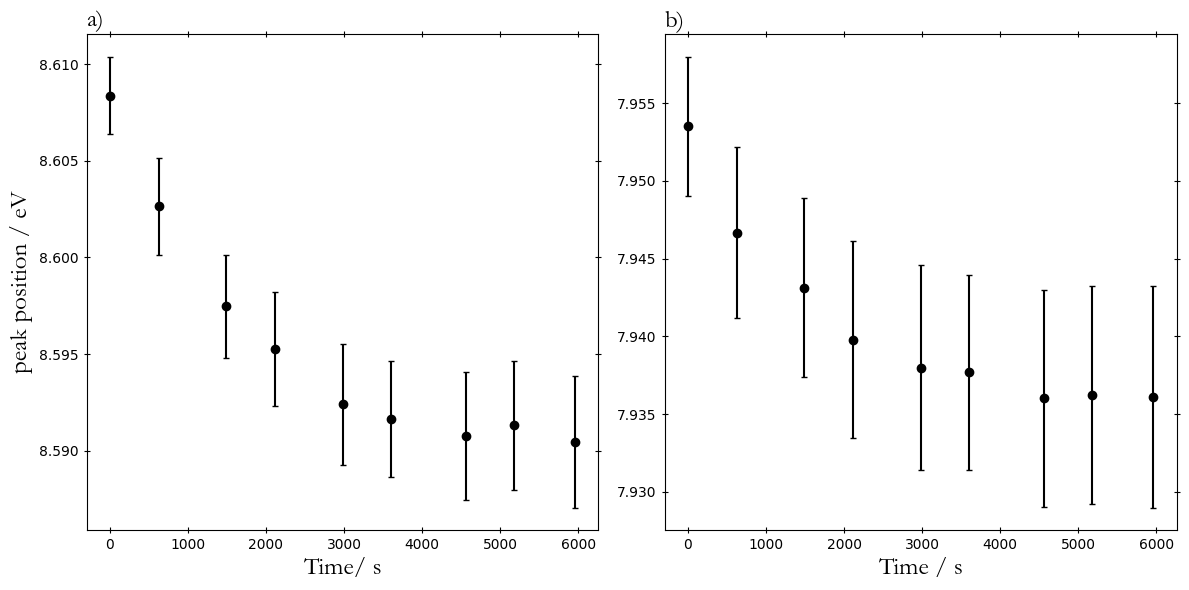

In [38]:
#    Extract the time evolution at 125 K and fit with Gaussians
#--------------------------------------------------------

# Find data files
#--------------------------------------------------------

# glob processed files
data_files = glob.glob('time/data/***.txt')

# Funciton definitions
#--------------------------------------------------------

#   Gaussian formula
def gaussian(x, A, x0, sig):
    return A*np.exp(-(x-x0)**2/(2*sig**2))

def multi_gaussian(x, *pars):
    g1 = gaussian(x, pars[0], pars[1], pars[2])
    g2 = gaussian(x, pars[3], pars[4], pars[5])
    g3 = gaussian(x, pars[6], pars[7], pars[8])
    g4 = gaussian(x, pars[9], pars[10], pars[11])
    # return g1 + g2 + g3 
    return g1 + g2 + g3 + g4

# Converting wavelength (nm) to energy (eV)
# Function to prevent zero values in an array
def preventDivisionByZero(some_array):
    corrected_array = some_array.copy()
    for i, entry in enumerate(some_array):
        # If element is zero, set to some small value
        if abs(entry) < float_info.epsilon:
            corrected_array[i] = float_info.epsilon
    
    return corrected_array

def WLtoE(wl):
    # Prevent division by zero error
    wl = preventDivisionByZero(wl)

    # E = h*c/wl            
    h = constants.h         # Planck constant
    c = constants.c         # Speed of light
    J_eV = constants.e      # Joule-electronvolt relationship
    
    wl_nm = wl * 10**(-9)   # convert wl from nm to m
    E_J = (h*c) / wl_nm     # energy in units of J
    E_eV = E_J / J_eV       # energy in units of eV
    
    return E_eV  

# Converting energy (eV) to wavelength (nm)
def EtoWL(E):
    # Prevent division by zero error
    E = preventDivisionByZero(E)
    
    # Calculates the wavelength in nm
    return constants.h * constants.c / (constants.e * E) * 10**9

def PlotGaussFit(name, x, data, fit, residuals_4gauss, gauss_peak_1,gauss_peak_2,gauss_peak_3,gauss_peak_4):
    
    ###
    
    fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios':[3,1]})
    fig.subplots_adjust(hspace=0) # Remove horizontal space between axes

    fig.suptitle('fit data with 4 Gaussians'+name, family="serif", fontsize=12)
    plt.xlabel('wavelength / eV', family="serif", fontsize=12)

    axs[1].plot(x,residuals_4gauss,'go:',label='res')

    axs[1].set_ylabel("residuals",family="serif", fontsize=12)  
    axs[0].plot(x,data,'b+:',label='data')

    axs[0].plot(x, gauss_peak_1, "g")
    axs[0].fill_between(x, gauss_peak_1.min(), gauss_peak_1, facecolor="green", alpha=0.5)

    axs[0].set_ylabel("absorbance",family="serif", fontsize=12)    
    axs[0].plot(x,  gauss_peak_2, "y")
    axs[0].fill_between(x, gauss_peak_2.min(), gauss_peak_2, facecolor="yellow", alpha=0.5)  

    axs[0].plot(x,  gauss_peak_3, "m")
    axs[0].fill_between(x, gauss_peak_3.min(), gauss_peak_3, facecolor="magenta", alpha=0.5)  

    axs[0].plot(x,  gauss_peak_4, "k")
    axs[0].fill_between(x, gauss_peak_4.min(), gauss_peak_4, facecolor="k", alpha=0.5)  
    
    axs[0].plot(x,  fit, "-k", label = 'Gaussian fit')

    #axs[0].annotate(residuals, xy =(150, max(df['absorbance_bk'])))
    #axs[0].text(0,0.7,'pars_4'+str(pars_4),transform=axs[0].transAxes)
    #axs[0].text(0,0.6,'pars_3'+str(pars_3),transform=axs[0].transAxes)
    #axs[0].text(0,0.5,'pars_2'+str(pars_2),transform=axs[0].transAxes)
    #axs[0].text(0,0.4,'pars_1'+str(pars_1),transform=axs[0].transAxes)

    axs[1].legend()
    axs[0].legend()


#   initial guess with bounds for eV fit
init_vals = [0.2, 8.6,0.38, #amp, pos, width
         0.05, 8.4, 0.172,
         0.3, 11.830, 1.22,
         0.029, 6.4, 0.21]

bounds_min = [0.01,8.0,0.37, # 8 eV peak
              0.01,7.2,0.1, # 7 eV peak
              0,10.9,1.0, # high energy background peak
              0.00,6.0,0.2] # low energy peak

bounds_max = [1.2,8.9,0.4,
              0.4,8.5,0.3,
              1.3,11.9,1.23,
              0.1,7.0,0.4]

#   create lists for data, temp & deposition
data_dict=[]
time_stamps = []


#   Load files and fit
#--------------------------------------------------------

for i in data_files:
       
    #   find temperature from data file name
    time = int(i[-8:-4])
    
    #   load data in datafram
    df = pd.read_csv(i, delimiter=' ', names=['wavelength', 'absorbance'])

    #   discard data below 117 nm and above 220 nm
    df = df.drop(df[df['wavelength']<117].index)

    #   set a linear background by finding the minimum point on the curve and drawing a linear line here
    linear_BkGd=df['absorbance'].min()
    #   substract bkg
    y = df['absorbance_bk'] = df['absorbance'] - linear_BkGd  
    
    # #make shorthand for wavelength
    x = WLtoE(df['wavelength'])

    #   fit Gaussian
    popt, pcov = curve_fit(multi_gaussian, x, df['absorbance_bk'], p0=init_vals, bounds=(bounds_min,bounds_max))
    
    perr_3gauss = np.sqrt(np.diag(pcov))

    pars_1 = popt[0:3]
    pars_2 = popt[3:6]
    pars_3 = popt[6:9]
    pars_4 = popt[9:12]
    gauss_peak_1 = gaussian(x, *pars_1)
    gauss_peak_2 = gaussian(x, *pars_2)
    gauss_peak_3 = gaussian(x, *pars_3)
    gauss_peak_4 = gaussian(x, *pars_4)
    fit = gauss_peak_1 + gauss_peak_2 + gauss_peak_3 + gauss_peak_4
    
    #calculate errors and residuals:
    df['residual_3gauss']=residual_2gauss = y - (multi_gaussian(x, *popt))
    df['Gauss_1'] = gauss_peak_1
    df['Gauss_2'] = gauss_peak_2
    df['Gauss_3'] = gauss_peak_3
    df['Gauss_4'] = gauss_peak_4
    df['Gauss_fit'] = fit
    residuals=sum((df['absorbance_bk']-(multi_gaussian(df['wavelength'], *popt)))**2)

    #   fit parameters
    #---------------------
    pars_err_1 = perr_3gauss[0:3] # divide the output parameteres into to arrays, one for the first Gaussian; a 2nd for Gaussian 2; etc
    pars_err_2 = perr_3gauss[3:6]
    pars_err_3 = perr_3gauss[6:9]
    pars_err_4 = perr_3gauss[9:12]
    
    #   Concatenate fits
    Gauss = np.concatenate((pars_1, pars_err_1, pars_2, pars_err_2, pars_3, pars_err_3, pars_4, pars_err_4))

    #   Append Gaus, Temp and Dep to respective lists
    data_dict.append(Gauss)
    time_stamps.append(time)
    
    # plot each fit, file by file
    #PlotGaussFit(str(time)+ 's', x, df['absorbance_bk'], fit, df['residual_3gauss'], gauss_peak_1,gauss_peak_2,gauss_peak_3,gauss_peak_4)
    
    # Save the dataframe to csv file
    
    #df.to_csv('exports/'+name+'.csv', index=False)

#put all of the fit outcomes into a dataframe called "p"
data_dict = np.array(data_dict)
time_stamps = np.array(time_stamps)
data = np.round(np.concatenate((time_stamps[:,None], data_dict), axis=1),8)
data_dict=dict(enumerate(data,0))

time_p = pd.DataFrame(data, columns=['time',
                                'ab1','peak1','sig1','ab1_err','peak1_err','sig1_err',
                                'ab2','peak2','sig2','ab2_err','peak2_err','sig2_err',
                                'ab3','peak3','sig3','ab3_err','peak3_err','sig3_err',
                                'ab4','peak4','sig4','ab4_err','peak4_err','sig4_err'])
time_p['temp']  =125.0
time_p['dep']  =3.0

time_p.to_csv('time_data_fits.csv', index=False)

extract_125K_last = time_p.iloc[[-1]].copy()

# Reset the index of the new DataFrame if needed
extract_125K_last.reset_index(drop=True, inplace=True)

#    Plot fit outcomes and parameter space explored, if required
#--------------------------------------------------------

def PlotGauss_PeakMax(dataframe):
    fig, axs = plt.subplots(4, 1, sharex=True, figsize=(4,7)) # I am making a 4 x 1 row x column grid
    fig.subplots_adjust(hspace=0.1)
    plt.xlabel('time stamp / s', family="garamond", fontsize=18)
    plt.rcParams['errorbar.capsize']=2
    dataframe.plot.scatter(x='time',y='peak1', yerr = 'peak1_err', ax=axs[1])
    dataframe.plot.scatter(x='time',y='peak2', yerr = 'peak2_err',ax=axs[2])
    dataframe.plot.scatter(x='time',y='peak3', yerr = 'peak3_err',ax=axs[0])
    dataframe.plot.scatter(x='time',y='peak4', yerr = 'peak4_err',ax=axs[3])
    #plt.xlim(120,145)
    plt.show()

def PlotFitSpace(dataframe):

    y_axis = np.ones(len(dataframe.peak1))
    fig, axs = plt.subplots(4, 3, sharex=False)
    fig.subplots_adjust(hspace=1)

    fig.suptitle('fit space explored', family="serif", fontsize=12)    
        
    axs[0,0].plot(time_p.sig1,y_axis,'ro')
    axs[0,0].set_xlim(bounds_min[2],bounds_max[2])
    axs[0,0].set_title('width')
    axs[0, 0].set_yticklabels([])
    axs[0,0].set_ylabel('144 nm')

    axs[1,0].plot(time_p.sig2,y_axis,'ro')
    axs[1,0].set_xlim(bounds_min[5],bounds_max[5])
    axs[1, 0].set_yticklabels([]) 
    axs[1,0].set_ylabel('155 nm')

    axs[2,0].plot(time_p.sig3,y_axis,'ro')
    axs[2,0].set_xlim(bounds_min[8],bounds_max[8])
    axs[2, 0].set_yticklabels([]) 
    axs[2,0].set_ylabel('BkGd')
    
    axs[3,0].plot(time_p.sig4,y_axis,'ro')
    axs[3,0].set_xlim(bounds_min[11],bounds_max[11])
    axs[3, 0].set_yticklabels([]) 
    axs[3,0].set_ylabel('contaminant')
    
    axs[0,1].plot(time_p.peak1,y_axis,'ro')
    axs[0,1].set_xlim(bounds_min[1],bounds_max[1])
    axs[0,1].set_yticklabels([]) 
    axs[0,1].set_title('pos')

    axs[1,1].plot(time_p.peak2,y_axis,'ro')
    axs[1,1].set_xlim(bounds_min[4],bounds_max[4])
    axs[1, 1].set_yticklabels([]) 

    axs[2,1].plot(time_p.peak3,y_axis,'ro')
    axs[2,1].set_xlim(bounds_min[7],bounds_max[7])
    axs[2, 1].set_yticklabels([]) 

    axs[3,1].plot(time_p.peak4,y_axis,'ro')
    axs[3,1].set_xlim(bounds_min[10],bounds_max[10])
    axs[3, 1].set_yticklabels([]) 
    
    axs[0,2].plot(time_p.ab1,y_axis,'ro')
    axs[0,2].set_xlim(bounds_min[0],bounds_max[0])
    axs[0, 2].set_yticklabels([]) 
    axs[0,2].set_title('amp')

    axs[1,2].plot(time_p.ab2,y_axis,'ro')
    axs[1,2].set_xlim(bounds_min[3],bounds_max[3])
    axs[1, 2].set_yticklabels([]) 

    axs[2,2].plot(time_p.ab3,y_axis,'ro')
    axs[2,2].set_xlim(bounds_min[6],bounds_max[6])
    axs[2, 2].set_yticklabels([]) 

    axs[3,2].plot(time_p.ab4,y_axis,'ro')
    axs[3,2].set_xlim(bounds_min[9],bounds_max[9])
    axs[3, 2].set_yticklabels([])  

#PlotGauss_PeakMax(time_p)
#PlotFitSpace(time_p)

#    Plot figure 3
#--------------------------------------------------------

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Panel 1: 8.5 eV peal
ax1.errorbar(time_p ['time'], time_p ['peak1'], yerr=time_p['peak1_err'], fmt='o', color='black', label='8.6 eV')
ax1.set_xlabel('Time/ s',family="garamond", fontsize=18)
ax1.set_ylabel('peak position / eV',family="garamond", fontsize=18)
ax1.set_title('a)',loc = 'left',family="garamond", fontsize=18)


#ax1.yaxis.set_minor_locator(plt.MultipleLocator(0.005))
#ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax1.yaxis.set_tick_params(right=True, labelright=False)
ax1.tick_params(axis='y', which='both', length=5,  direction='inout')

# Adding ticks to both top and bottom of x-axis
ax1.xaxis.set_ticks_position('both')
ax1.tick_params(axis='x', which='both', length=5,  direction='inout')

# Panel 2: Column1 vs Column3 with error bars from Column5
ax2.errorbar(time_p ['time'], time_p ['peak2'], yerr=time_p['peak2_err'], fmt='o', color='black', label='8 eV')
ax2.set_xlabel('Time / s',family="garamond", fontsize=18)
#ax2.set_ylabel('peak position / eV',family="garamond", fontsize=18)
ax2.set_title('b)',loc = 'left',family="garamond", fontsize=18)

#ax2.yaxis.set_minor_locator(plt.MultipleLocator(0.005))
#ax2.yaxis.set_tick_params(labelleft=False)
ax2.yaxis.set_tick_params(right=True, labelright=False)
ax2.tick_params(axis='y', which='both', length=5,  direction='inout')

# Adding ticks to both top and bottom of x-axis
ax2.xaxis.set_ticks_position('both')
ax2.tick_params(axis='x', which='both', length=5,  direction='inout')

# Adjust layout
plt.tight_layout()
# Save the figure as a PNG file
fig.savefig('Figure_3_a.png', format='png')
# Show the plot
#plt.show()


In [40]:
##Find depositions at same thickness/absorbance for each temperature and save results
obs_all_data = p.loc[(p['ab1'] > 0.41) & (p['ab1'] < 0.71), ['temp','dep','peak1','peak2', 'peak1_err','peak2_err']]

#Replace the fit at 125 K with the better fit from the time-resolved sata
# Get the columns of obs_all_data
obs_all_data_columns = obs_all_data.columns
# Filter extract_125K_last to only contain columns present in obs_all_data
filtered_extract_125K_last = extract_125K_last[obs_all_data_columns]
# Replace the values in obs_all_data with values from filtered_extract_125K_last
condition = (obs_all_data['temp'] == 125) & (obs_all_data['dep'] == 3)
obs_all_data.loc[condition, obs_all_data_columns] = filtered_extract_125K_last.values

# Since this condition is not unique at some temperatures remove ambiguity
temperatures = np.array(obs_all_data.temp)
depositions = np.array(obs_all_data.dep)
peak1_positions = np.array(obs_all_data.peak1)
peak2_positions = np.array(obs_all_data.peak2)
peak1_err = np.array(obs_all_data.peak1_err)
peak2_err = np.array(obs_all_data.peak2_err)

#get list of required temps and deps
temp_dep_pos = list(zip(temperatures, depositions, peak1_positions, peak2_positions,peak1_err ,peak2_err ))

filtered_temp_dep_pos  =  []


for i in range(1, len(temp_dep_pos)):
#    # If the current element is not the same as the previous element
    if temp_dep_pos[i][0] != temp_dep_pos[i-1][0]:
#        # Add the previous element to the filtered list
        filtered_temp_dep_pos.append(temp_dep_pos[i-1])
## Add the last element
filtered_temp_dep_pos.append(temp_dep_pos[-1])

#send this data to a dataframe
filtered_temp_dep_pos_df = pd.DataFrame(filtered_temp_dep_pos, columns=['Temperature_K', 'depositon#', '8_5eV_peak_eV', '8eV_peak_eV', '8_5eV_err', '8eV_err'])
df_selected = filtered_temp_dep_pos_df[['Temperature_K', '8_5eV_peak_eV', '8eV_peak_eV','8_5eV_err', '8eV_err']]
# Saving the selected columns to a CSV file
df_selected.to_csv('water_best_positions.csv', index=False)


# Save the spont rows to a text file 
df_spont = df_selected[df_selected['Temperature_K'] > 126]
df_spont.to_csv('water_spont_data.csv', index=False)



<Figure size 1000x600 with 0 Axes>

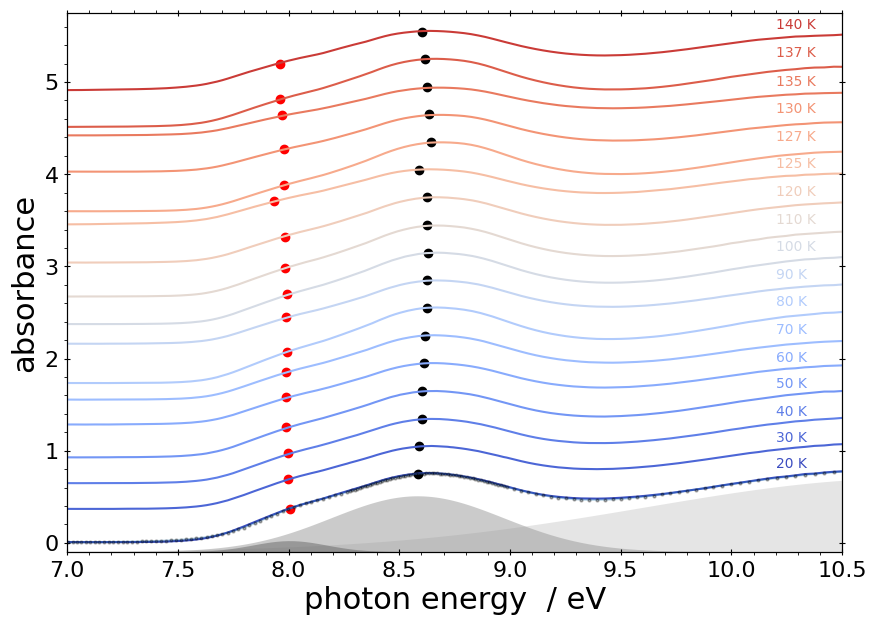

In [42]:
#    Plot figure 1
#--------------------------------------------------------

peak1_values = filtered_temp_dep_pos_df['8_5eV_peak_eV']
peak2_values = filtered_temp_dep_pos_df['8eV_peak_eV']
filtered_temp = filtered_temp_dep_pos_df['Temperature_K']

#Get the csv data that stores xy data for each required temp and dep
best_spectra = []

#now extract the bkgd subtracted datacurves for filtered data sets
for fil_temp_dep_pos in filtered_temp_dep_pos:
    #   adjust for file naming - i.e. add  0.5 K to 127.5 and 137.5 K
    temperature_str = str(fil_temp_dep_pos[0])       
    temperature_str = temperature_str[:-2]
    if len(temperature_str) == 2:
    # Add a zero to the beginning
        temperature_str = '0' + temperature_str
    if temperature_str[-1] == "7":
    # add "-5"
        temperature_str += "-5"
    #add text 
    temperature_str +="K_dep"+str(fil_temp_dep_pos[1])
    temperature_str  = temperature_str[:-1]+"csv"
    best_spectra.append(temperature_str)

plt.figure(figsize=(10, 6))
# Define the colormap
cmap = plt.get_cmap('coolwarm')

# Define the offset for the waterfall plot
offset = 0

#define function to find the absorbance and energy value that corresponds to a peak position and add an offset
def find_closest_match(df, peak_values, i, offset): 
    # give
        #df = dataframe
        #peak_values = array of values to search through
        #i = which peak value to use
        #offset = any offset that should be applied
    
    # Find the row in 'df' where 'photon_energy' is closest to 'peak"x"_values[i]'
    closest_row = df.iloc[(df['photon_energy'] - peak_values[i]).abs().argsort()[:1]]
    
    # Get the 'index', 'absorbance' and 'energy' values from the closest row and add the 'offset'
    index_best_value = closest_row.index[0]
    absorbance_value_peak1 = closest_row['absorbance'].iloc[0] + offset
    energy_value_peak1 = closest_row['photon_energy'].iloc[0]
    # Return the result
    closest_xy = (index_best_value , energy_value_peak1 , absorbance_value_peak1)
    return closest_xy

fig, ax1 = plt.subplots(figsize=(10,7))
#ax1.set_title('Figure 1. Peak shifts at each deposition temperature')

for i, file in enumerate (sorted(best_spectra)):
    
    # Construct the full file path
    file_path = os.path.join(export_path, file)    
    # Read the csv file into a dataframe
    df = pd.read_csv(file_path)    
    #Convert the mn values in eV
    df['photon_energy'] = WLtoE(df.iloc[:, 0])  

    # Plot the first two columns of the dataframe and add a point for the peak maximum
    
    peak_energy = find_closest_match(df, peak1_values, i, offset) #find absorbance at top of peak 1

    #plt.plot(peak1_values[i], find_closest_match(df, peak1_values,i, offset)[2]+offset-(find_closest_match(df, peak1_values,i, offset)[2]), 'ko') 
    ax1.plot(peak1_values[i], offset, 'ko') 
    ax1.plot(peak2_values[i], find_closest_match(df, peak2_values,i, offset)[2]+offset-(find_closest_match(df, peak1_values,i, offset)[2]), 'ro') 
    
    
    absorbance = df['absorbance']  + offset  #add the offset to the absorbance column for plotting
    #print(df, peak1_values,i, offset)
    df['Normalized Absorbance'] = absorbance - df.iloc[find_closest_match(df, peak1_values,i, offset)[0], 2]
    legend_label =str(filtered_temp[i])
    legend_label=legend_label[:-2]+' K'
    ax1.plot(df['photon_energy'], df['Normalized Absorbance'], label=legend_label, color=cmap(i / len(best_spectra)))
    ax1.text(10.2, df['Normalized Absorbance'].max()+0.02,legend_label,color=cmap(i / len(best_spectra)))
        
    # Increase the offset
    offset += 0.3
    
#Add the Gaussian fit for the first spectrum to the plot
first_spectrum = pd.read_csv(os.path.join(export_path, best_spectra[0]))
first_spectrum['photon_energy'] = WLtoE(first_spectrum.iloc[:, 0])
check_index = find_closest_match(first_spectrum, peak1_values,0, 0)[0]
offset = 0.1
first_spectrum['Normalized_Gauss_3'] = first_spectrum['Gauss_3'] - first_spectrum.iloc[find_closest_match(first_spectrum, peak1_values,0, 0)[0], 2]-offset
#plt.plot(first_spectrum['photon_energy'],first_spectrum['Normalized_Gauss_3'], color = '0.8')
ax1.fill_between(first_spectrum['photon_energy'], first_spectrum['Normalized_Gauss_3'].min(), first_spectrum['Normalized_Gauss_3'], facecolor="0.8", alpha=0.5)

first_spectrum['Normalized_Gauss_1'] = first_spectrum['Gauss_1'] - first_spectrum.iloc[find_closest_match(first_spectrum, peak1_values,0, 0)[0], 2]-offset
#plt.plot(first_spectrum['photon_energy'],first_spectrum['Normalized_Gauss_1'], color = '0.6')
ax1.fill_between(first_spectrum['photon_energy'], first_spectrum['Normalized_Gauss_1'].min(), first_spectrum['Normalized_Gauss_1'], facecolor='0.6', alpha=0.5)

first_spectrum['Normalized_Gauss_2'] = first_spectrum['Gauss_2'] - first_spectrum.iloc[find_closest_match(first_spectrum, peak1_values,0, 0)[0], 2]-offset
#plt.plot(first_spectrum['photon_energy'],first_spectrum['Normalized_Gauss_2'], color = '0.4')
ax1.fill_between(first_spectrum['photon_energy'], first_spectrum['Normalized_Gauss_2'].min(), first_spectrum['Normalized_Gauss_2'], facecolor="0.4", alpha=0.5)

first_spectrum['Normalized_Gauss_4'] = first_spectrum['Gauss_4'] - first_spectrum.iloc[find_closest_match(first_spectrum, peak1_values,0, 0)[0], 2]-offset
#plt.plot(first_spectrum['photon_energy'],first_spectrum['Normalized_Gauss_4'], color = '0.2')
ax1.fill_between(first_spectrum['photon_energy'], first_spectrum['Normalized_Gauss_4'].min(), first_spectrum['Normalized_Gauss_4'], facecolor="0.2", alpha=0.5)

first_spectrum['Normalized_Gauss_fit'] = first_spectrum['Gauss_fit'] - first_spectrum.iloc[find_closest_match(first_spectrum, peak1_values,0, 0)[0], 2]
ax1.plot(first_spectrum['photon_energy'],first_spectrum['Normalized_Gauss_fit'],marker='.', markersize=4, markerfacecolor='black', markeredgecolor='black', alpha = 0.3)

ax1.set_xlabel('photon energy  / eV', fontsize = 22)
ax1.set_xlim(7.0,10.5)
ax1.tick_params(axis='x', direction='inout', labelsize = 16, length=5, top = True)
ax1.minorticks_on()
ax1.tick_params(axis='x', which='minor', direction='out', length=2, top=True, bottom=True)

ax1.tick_params(axis='y', direction='inout', length=5, labelsize = 16)
ax1.set_ylabel('absorbance', fontsize = 22)

#adjust the y-ticks so that 0 is at 0
yticks = np.array([0,1,2,3,4,5,6])
ax1.set_yticks(first_spectrum['Normalized_Gauss_fit'].min()+yticks, yticks)
ax1.set_ylim(first_spectrum['Normalized_Gauss_4'].min(),5)
#ax1.tick_params(axis='y', which='minor', labelsize = 22, direction='out', length=0)

# Create a twin y-axis
ax2 = ax1.twinx()
# Label the secondary y and x -axes
ax2.set_yticks(first_spectrum['Normalized_Gauss_fit'].min()+yticks, yticks)
ax2.tick_params(axis='y', direction='inout', labelsize = 18, length=5,labelright=False)
ax2.set_ylim(first_spectrum['Normalized_Gauss_4'].min(),5)

#plt.legend()

# Save the figure as a PNG file
fig.savefig('Figure_1.png', format='png')

plt.show()


Fitted parameters - peak 1:
a = 0.018535071108840406
b = 0.000616173368476363
c = 8.589938170876021
Time constant for decay for peak 1 = 1622.92 ± 100.18 s
Fitted parameters - peak 2:
a = 0.017670925770894116
b = 0.0006498614952831905
c = 7.935597593393984
Time constant for decay for peak 2 = 1538.79 ± 135.53 s


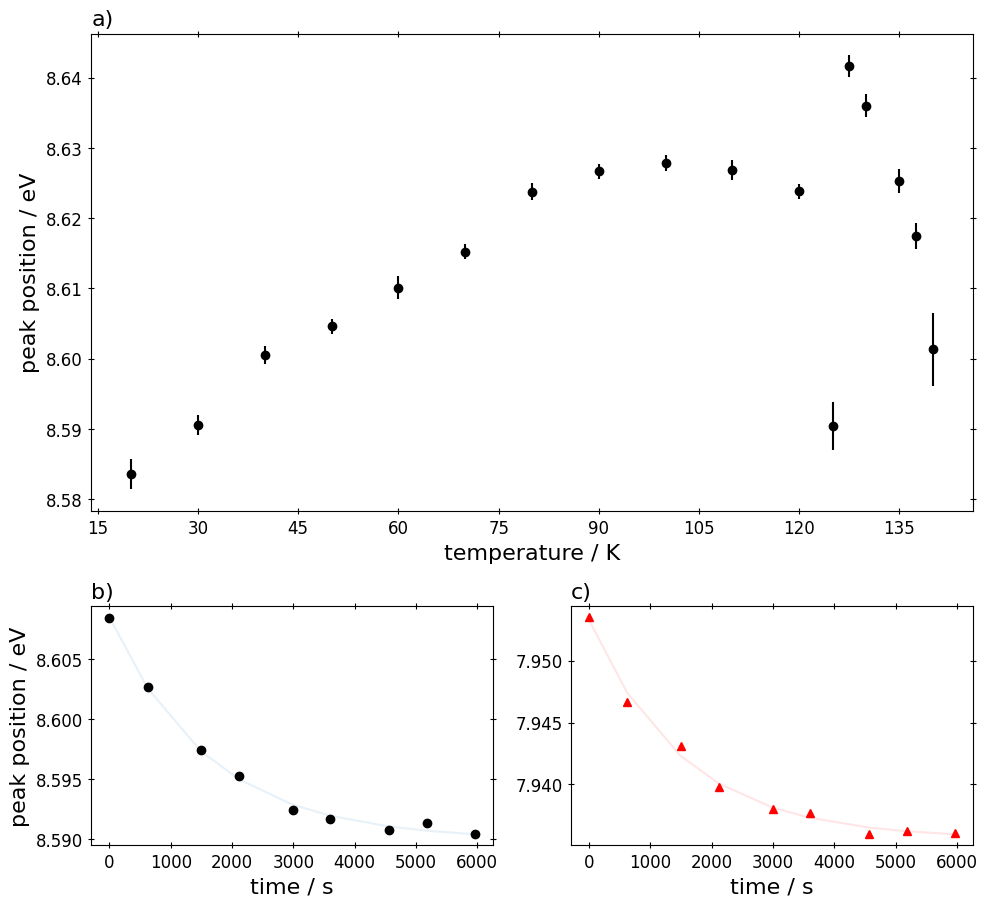

In [30]:
## Figure 2
### ------

#print(time_p)

#Fit exponentials to the time resolved data
# Define the exponential function to fit
def exponential_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

# Generate example data

x_data = time_p['time']
y_data1 = time_p['peak1']
y_data2 = time_p['peak2']

# Initial guess for the parameters [a, b, c]
initial_guess = [2, 0.001, 1]

# Fit the exponential decay function to the data
params1, covariance1 = curve_fit(exponential_decay, x_data, y_data1, p0=initial_guess)
params2, covariance2 = curve_fit(exponential_decay, x_data, y_data2, p0=initial_guess)

# Extract the fitted parameters
a_fit1, b_fit1, c_fit1 = params1
a_fit2, b_fit2, c_fit2 = params2

# Generate fitted y-values using the fitted parameters
y_fit1 = exponential_decay(x_data, a_fit1, b_fit1, c_fit1)
y_fit2 = exponential_decay(x_data, a_fit2, b_fit2, c_fit2)

# Extract standard errors of the parameters from the covariance matrix
perr1 = np.sqrt(np.diag(covariance1))
perr2 = np.sqrt(np.diag(covariance2))

# Calculate the error on the time constant
tau1 = 1 / b_fit1
tau2 = 1 / b_fit2

tau1_err = perr1[1] / (b_fit1 ** 2)
tau2_err = perr2[1] / (b_fit2 ** 2)

# Print the results
print(f"Fitted parameters - peak 1:\na = {a_fit1}\nb = {b_fit1}\nc = {c_fit1}")
print(f"Time constant for decay for peak 1 = {round(tau1, 2)} ± {round(tau1_err, 2)} s")

print(f"Fitted parameters - peak 2:\na = {a_fit2}\nb = {b_fit2}\nc = {c_fit2}")
print(f"Time constant for decay for peak 2 = {round(tau2, 2)} ± {round(tau2_err, 2)} s")

# Create a figure with a custom grid layout
fig = plt.figure(figsize=(10, 12))
gs = GridSpec(3, 2, height_ratios=[2, 1, 1], width_ratios=[1, 1])

# Panel 1: Temperature-dependent data (spans the top row)
ax1 = fig.add_subplot(gs[0, :])
ax1.errorbar(filtered_temp_dep_pos_df['Temperature_K'], filtered_temp_dep_pos_df['8_5eV_peak_eV'], yerr=filtered_temp_dep_pos_df['8_5eV_err'], fmt='o', color='black', label='8.5 eV')
ax1.set_xlabel('temperature / K', fontsize=16)
ax1.set_ylabel('peak position / eV', fontsize=16)
ax1.set_title('a)', loc='left', fontsize=16)
ax1.yaxis.set_tick_params(right=True, labelright=False)
ax1.tick_params(axis='y', which='both', length=5, labelsize=12, direction='inout')
ax1.xaxis.set_ticks_position('both')
ax1.tick_params(axis='x', which='both', length=5, labelsize=12, direction='inout')
ax1.xaxis.set_major_locator(MultipleLocator(15))

# Panel 2: Time-dependent data (left bottom)
ax3 = fig.add_subplot(gs[1, 0])
ax3.errorbar(x_data, y_data1, fmt='o', color='black', label='8.6 eV')
ax3.plot(x_data, y_fit1, alpha = 0.1)
ax3.set_xlabel('time / s',  fontsize=16)
ax3.set_ylabel('peak position / eV',  fontsize=16)
ax3.set_title('b)', loc='left', fontsize=16)
ax3.yaxis.set_tick_params(right=True, labelright=False)
ax3.tick_params(axis='y', which='both', length=5, labelsize=12, direction='inout')
ax3.xaxis.set_ticks_position('both')
ax3.tick_params(axis='x', which='both', length=5, labelsize=12, direction='inout')

# Panel 3: Additional plot (right bottom)
ax5 = fig.add_subplot(gs[1, 1])
ax5.errorbar(x_data, y_data2, fmt='^', color='red', label='8 eV')
ax5.plot(x_data, y_fit2,'r', alpha = 0.1)
ax5.set_xlabel('time / s', fontsize=16)
#ax5.set_ylabel('peak position / eV', fontsize=16)
ax5.set_title('c)', loc='left', fontsize=16)
ax5.yaxis.set_tick_params(right=True, labelright=False)
ax5.tick_params(axis='y', which='both', length=5, labelsize=12, direction='inout')
ax5.xaxis.set_ticks_position('both')
ax5.tick_params(axis='x', which='both', length=5, labelsize=12, direction='inout')

# Create a legend for the second panel (ax3) only
#lines, labels = ax3.get_legend_handles_labels()
#lines2, labels2 = ax4.get_legend_handles_labels()
#ax3.legend(lines + lines2, labels + labels2, loc='upper right', frameon=False)

# Adjust layout to add space between the panels
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)  # Increase the space between the panels

# Save the figure as a PNG file
fig.savefig('Figure_2.png', format='png')

# Show the plot
plt.show()

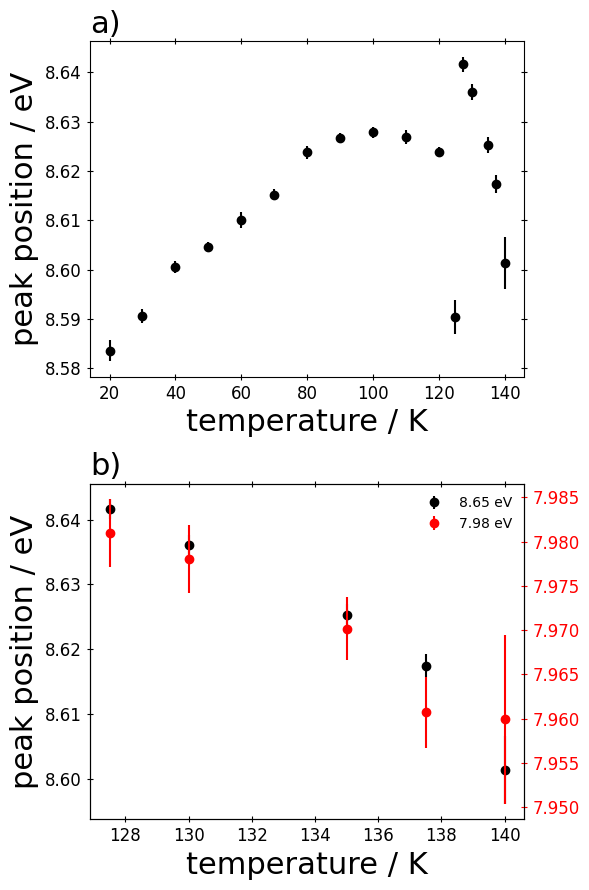

In [32]:
#    Plot figure 3
#--------------------------------------------------------

fig, (ax1, ax3) = plt.subplots(nrows=2, ncols=1, figsize=(6, 9))

# Adjust the space between subplots
#plt.subplots_adjust(wspace=9)  # Increase the space between the panels

# Panel 1: 8.5 eV peal
ax1.errorbar(filtered_temp_dep_pos_df['Temperature_K'], filtered_temp_dep_pos_df['8_5eV_peak_eV'], yerr=filtered_temp_dep_pos_df['8_5eV_err'], fmt='o', color='black', label='Panel 1')
ax1.set_xlabel('temperature / K', fontsize=22)
ax1.set_ylabel('peak position / eV', fontsize=22)
ax1.set_title('a)',loc = 'left', fontsize=22)
ax1.yaxis.set_tick_params(right=True, labelright=False)
ax1.tick_params(axis='y', which='both', length=5,  labelsize = 12, direction='inout')

# Adding ticks to both top and bottom of x-axis
ax1.xaxis.set_ticks_position('both')
ax1.tick_params(axis='x', which='both', length=5,  labelsize = 12, direction='inout')

# Panel 2: Column1 vs Column3 with error bars from Column5
#ax2.errorbar(filtered_temp_dep_pos_df['Temperature_K'], filtered_temp_dep_pos_df['8eV_peak_eV'], yerr=filtered_temp_dep_pos_df['8eV_err'], fmt='o', color='black', label='Panel 2')
#ax2.set_xlabel('temperature / K', fontsize=28)
#ax2.set_ylabel('peak position / eV', fontsize=18)
#ax2.set_title('b)',loc = 'left', fontsize=28)

#ax2.yaxis.set_minor_locator(plt.MultipleLocator(0.005))
#ax2.yaxis.set_tick_params(labelleft=False)
#ax2.yaxis.set_tick_params(right=True, labelright=False)
#ax2.tick_params(axis='y', which='both', length=5,  labelsize = 16, direction='inout')

# Adding ticks to both top and bottom of x-axis
#ax2.xaxis.set_ticks_position('both')
#ax2.tick_params(axis='x', which='both', length=5,  labelsize = 16, direction='inout')

# Panel 2: 

ax3.errorbar(df_spont['Temperature_K'], df_spont['8_5eV_peak_eV'], yerr=df_spont['8_5eV_err'], fmt='o', color='black', label='8.65 eV')
ax3.set_xlabel('temperature / K',  fontsize=22)
ax3.set_ylabel('peak position / eV', fontsize=22)
ax3.set_title('b)', loc='left', fontsize=22)
ax3.yaxis.set_tick_params(right=True, labelright=False)
ax3.tick_params(axis='y', which='both', length=5, labelsize=12,direction='inout')
ax3.xaxis.set_ticks_position('both')
ax3.tick_params(axis='x', which='both', length=5, labelsize=12, direction='inout')

# Create a second y-axis for the second subplot
ax4 = ax3.twinx()
ax4.errorbar(df_spont['Temperature_K'], df_spont['8eV_peak_eV'], yerr=df_spont['8eV_err'], fmt='o', color='red', label='7.98 eV')
#ax4.set_ylabel('peak position / eV',  fontsize=22, color='red')
ax4.yaxis.set_tick_params(right=True, labelright=True, colors='red')
ax4.tick_params(axis='y', which='both', length=5, labelsize=12, direction='inout', colors='red')

# Adjust layout to add space between the panels
plt.tight_layout()

# Create a legend for the second panel only
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax4.get_legend_handles_labels()
ax3.legend(lines1+lines2, labels1+labels2, frameon=False)

# Save the figure as a PNG file
fig.savefig('Figure2_combined_v2.png', format='png')

# Show the plot
plt.show()





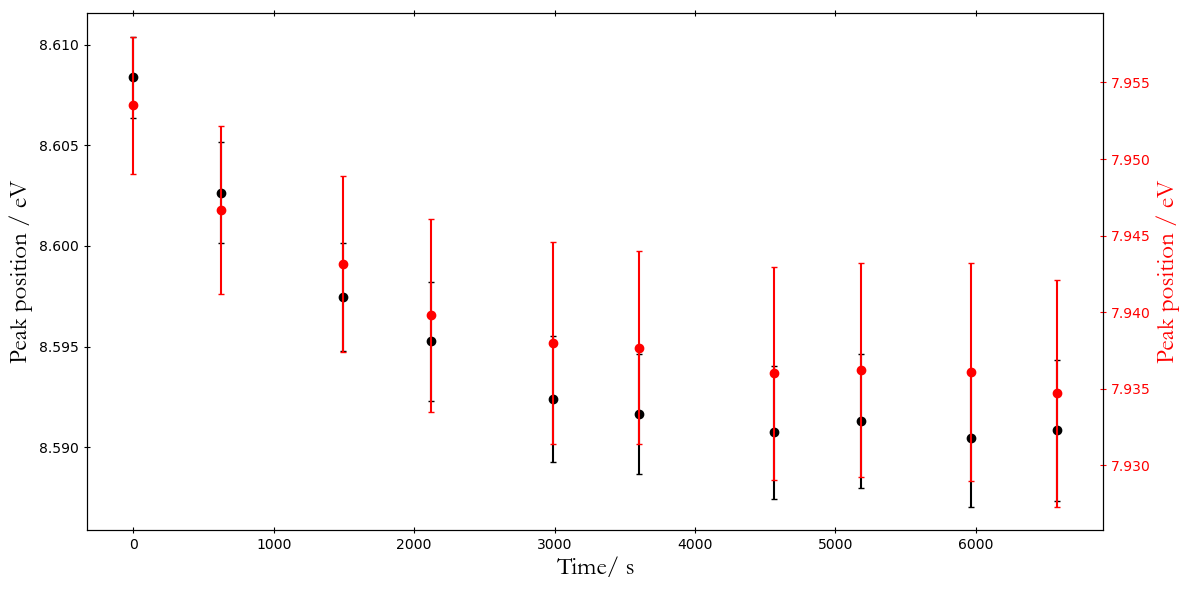

In [188]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Panel 1: 8.5 eV peak
ax1.errorbar(time_p['time'], time_p['peak1'], yerr=time_p['peak1_err'], fmt='o', color='black', label='8.6 eV')
ax1.set_xlabel('Time/ s', family="garamond", fontsize=18)
ax1.set_ylabel('Peak position / eV', family="garamond", fontsize=18)
#ax1.set_title('a)', loc='left', family="garamond", fontsize=18)
ax1.yaxis.set_tick_params(right=True, labelright=False)
ax1.tick_params(axis='y', which='both', length=5, direction='inout')
ax1.xaxis.set_ticks_position('both')
ax1.tick_params(axis='x', which='both', length=5, direction='inout')

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Panel 2: Column1 vs Column3 with error bars from Column5
ax2.errorbar(time_p['time'], time_p['peak2'], yerr=time_p['peak2_err'], fmt='o', color='red', label='8 eV')
ax2.set_ylabel('Peak position / eV', family="garamond", fontsize=18, color='red')
#ax2.set_title('b)', loc='left', family="garamond", fontsize=18)
ax2.yaxis.set_tick_params(right=True, labelright=True, colors='red')
ax2.tick_params(axis='y', which='both', length=5, direction='inout', colors='red')

# Adjust layout
plt.tight_layout()

# Save the figure as a PNG file
fig.savefig('Figure_3b.png', format='png')
# Show the plot
plt.show()


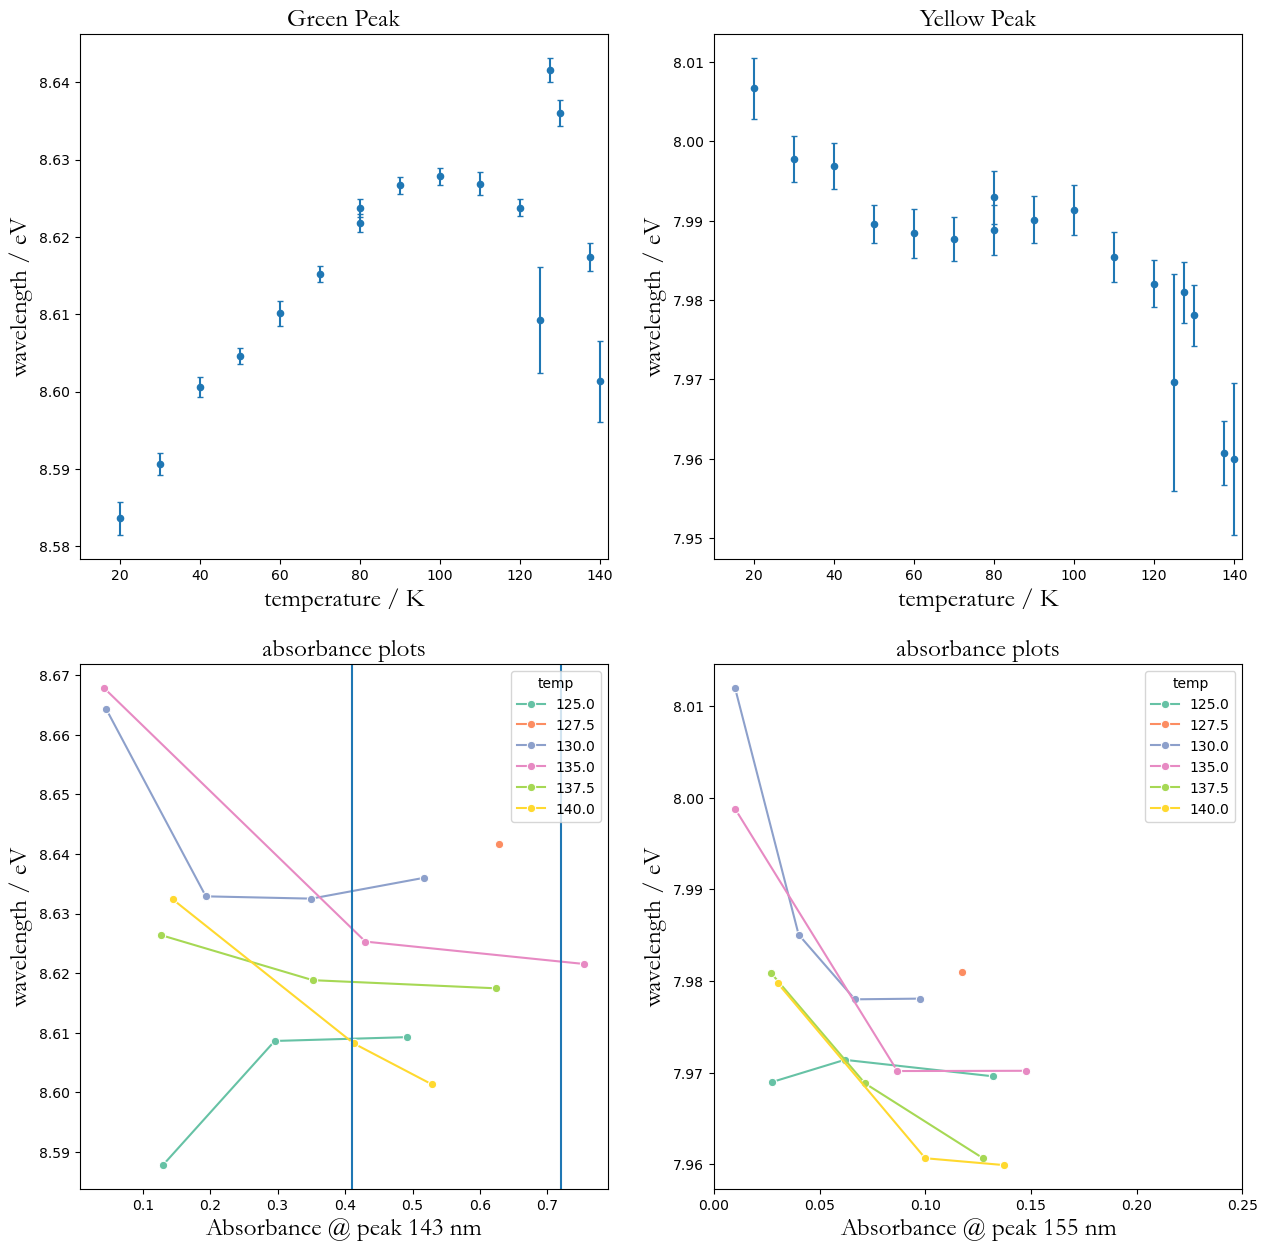

In [8]:
fig, axs = plt.subplots(2, 2, sharex=False, figsize=(15,15)) # I am making a 4 x 4 row x column grid
fig.subplots_adjust(hspace=0.2)
fig.subplots_adjust(wspace=0.2)
       

p = pd.DataFrame(data, columns=['temp','dep',
                                'ab1','peak1','sig1','ab1_er','peak1_er','sig1_er',
                                'ab2','peak2','sig2','ab2_er','peak2_er','sig2_er',
                                'ab3','peak3','sig3','ab3_er','peak3_er','sig3_er',
                                'ab4','peak4','sig4','ab4_er','peak4_er','sig4_er'])

#fit_polynomial_same_temp(p, 'ab2', 'peak2', 'temp', 2)


plt.rcParams['errorbar.capsize']=2
#   144 nm peak
p.loc[(p.ab1>0.47) & (p.ab1<0.71)].plot.scatter(x='temp',y='peak1', yerr = 'peak1_er', ax=axs[0,0])
#   155 nm peak
p.loc[(p.ab1>0.47) & (p.ab1<0.71)].plot.scatter(x='temp',y='peak2', yerr = 'peak2_er',ax=axs[0,1])
#   115 nm peak
#p.loc[(p.ab1>0.47) & (p.ab1<0.71)].plot.scatter(x='temp',y='peak3', yerr = 'peak3_er',ax=axs[0])
#   190 nm peak
#p.loc[(p.ab1>0.47) & (p.ab1<0.71)].plot.scatter(x='temp',y='peak4', yerr = 'peak4_er',ax=axs[3])
axs[0,0].set_xlim(10,142)
axs[0,1].set_xlim(10,142)
#axs[0,0].set_ylim(143.1,144.3)
axs[0,0].set_title('Green Peak', family="garamond", fontsize=18)
axs[0,1].set_title('Yellow Peak', family="garamond", fontsize=18)
axs[0,0].set_xlabel('temperature / K', family="garamond", fontsize=18)
axs[0,1].set_xlabel('temperature / K', family="garamond", fontsize=18)
axs[0,1].set_ylabel('wavelength / eV', family="garamond", fontsize=18)
axs[0,0].set_ylabel('wavelength / eV', family="garamond", fontsize=18)


sns.lineplot(data=p.loc[p.temp>120], palette = "Set2", x='ab1',y='peak1', marker='o', hue='temp',  ax=axs[1,0])
#sns.lineplot(data=p, palette = "Set2", x='ab1',y='peak1', marker='o', hue='temp',  ax=axs[1,0])
#   155 nm peak
sns.lineplot(data=p.loc[p.temp>120], palette = "Set2", x='ab2',y='peak2', marker='o', hue='temp', ax=axs[1,1])
#sns.lineplot(data=p, palette = "Set2", x='ab2',y='peak2', marker='o', hue='temp', ax=axs[1,1])

axs[1,0].set_xlabel('Absorbance @ peak 143 nm', family="garamond", fontsize=18)
axs[1,0].set_ylabel('wavelength / eV', family="garamond", fontsize=18)
axs[1,0].set_title('absorbance plots', family="garamond", fontsize=18)
axs[1,1].set_xlabel('Absorbance @ peak 155 nm', family="garamond", fontsize=18)
axs[1,1].set_ylabel('wavelength / eV', family="garamond", fontsize=18)
axs[1,1].set_title('absorbance plots', family="garamond", fontsize=18)
axs[1,1].set_xlim(0.0,0.25)
#axs[1,1].set_ylim(155.0,157.1)

axs[1,0].axvline(x = 0.41,    # Line on x = 2
           ymin = 0, # Bottom of the plot
           ymax = 1) 
axs[1,0].axvline(x = 0.72,    # Line on x = 2
           ymin = 0, # Bottom of the plot
           ymax = 1) 
#axs[1,1].axvline(x = 0.12,    # Line on x = 2
#           ymin = 0, # Bottom of the plot
#           ymax = 1) 
#axs[1,1].axvline(x = 0.18,    # Line on x = 2
#           ymin = 0, # Bottom of the plot
#           ymax = 1) 


#plt.show()

fig.savefig('water_spont_peaks.png')

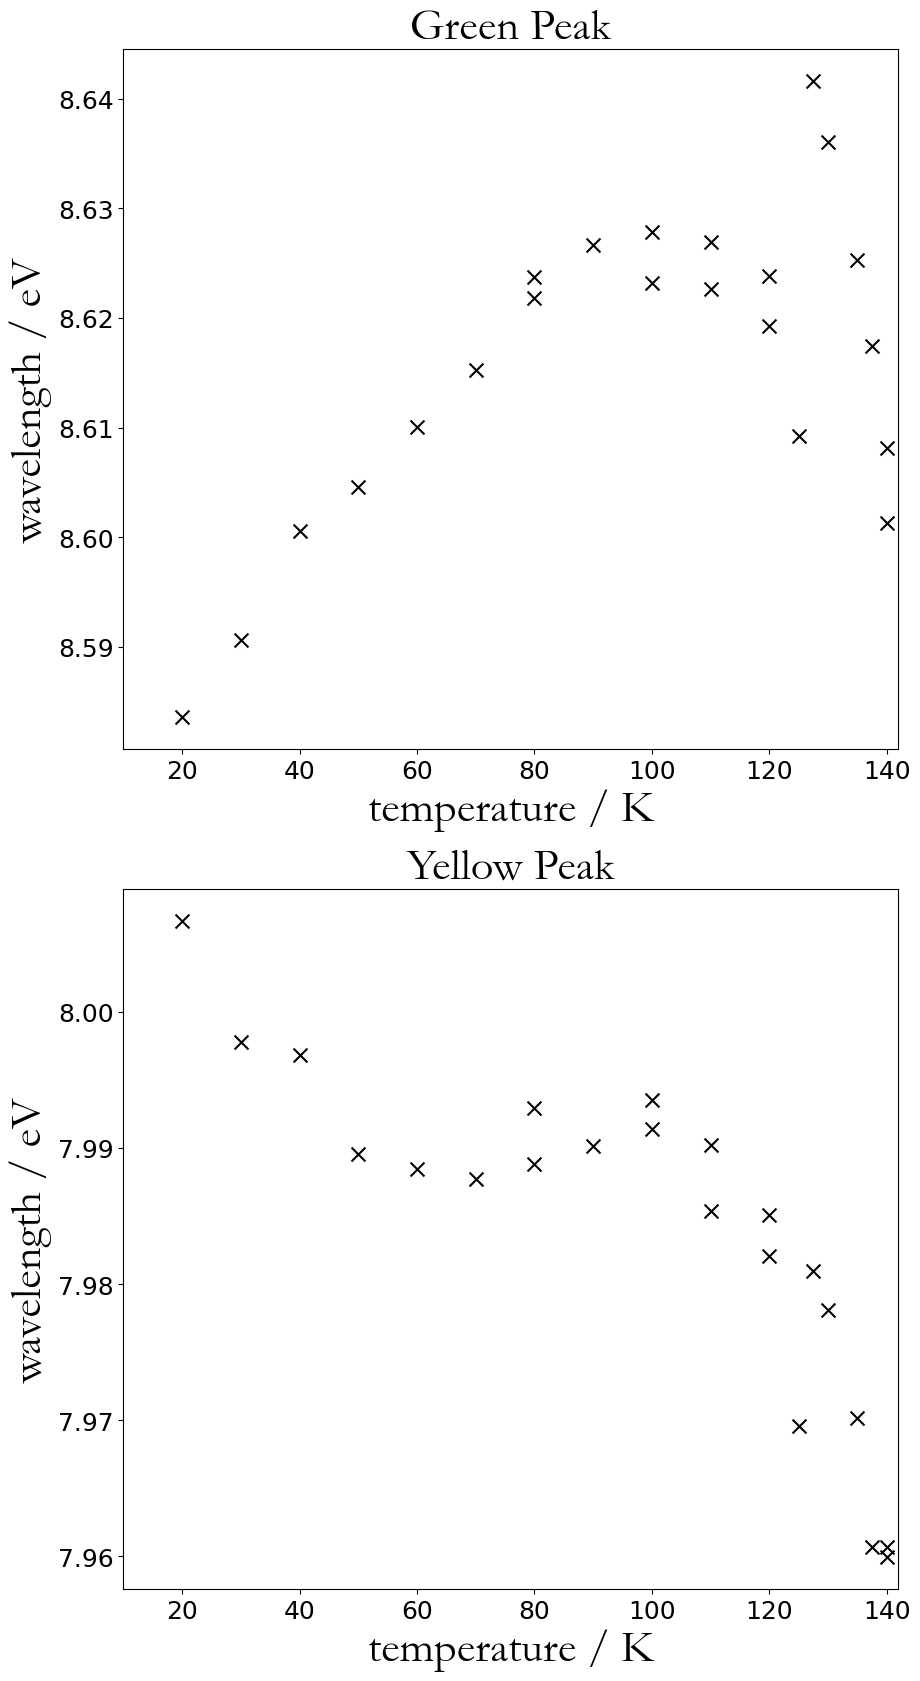

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a 2x1 subplot
fig, axs = plt.subplots(2, 1, sharex=False, figsize=(10, 20))
fig.subplots_adjust(hspace=0.2)

# Read data from CSV files
p_143 = pd.read_csv('water_143 all positions for Gauss2.txt', delim_whitespace=True, header=0)
p_155 = pd.read_csv('water_155 all positions for Gauss2.txt', delim_whitespace=True, header=0)

# Rename columns if necessary
p_143.columns = ['temp', 'position']
p_155.columns = ['temp', 'position']

# Plot data on the respective axes
p_143.plot.scatter(x='temp', y='position', ax=axs[0], color='black', marker='x', s=100)
p_155.plot.scatter(x='temp', y='position', ax=axs[1], color='black', marker='x', s=100)

# Set x and y limits
axs[0].set_xlim(10, 142)
axs[1].set_xlim(10, 142)

# Set titles and labels
axs[0].set_title('Green Peak', family="garamond", fontsize=32)
axs[1].set_title('Yellow Peak', family="garamond", fontsize=32)
axs[0].set_xlabel('temperature / K', family="garamond", fontsize=32)
axs[1].set_xlabel('temperature / K', family="garamond", fontsize=32)
axs[0].set_ylabel('wavelength / eV', family="garamond", fontsize=32)
axs[1].set_ylabel('wavelength / eV', family="garamond", fontsize=32)
# Update tick label font size
axs[0].tick_params(axis='both', which='major', labelsize=18)
axs[1].tick_params(axis='both', which='major', labelsize=18)

plt.show()


C:\Users\au302163\AppData\Local\Temp\ipykernel_14232\819562470.py:44: RankWarning: Polyfit may be poorly conditioned
  poly_data = fit_polynomial_same_temp(p, 'ab1', 'peak1', 'temp', 2)


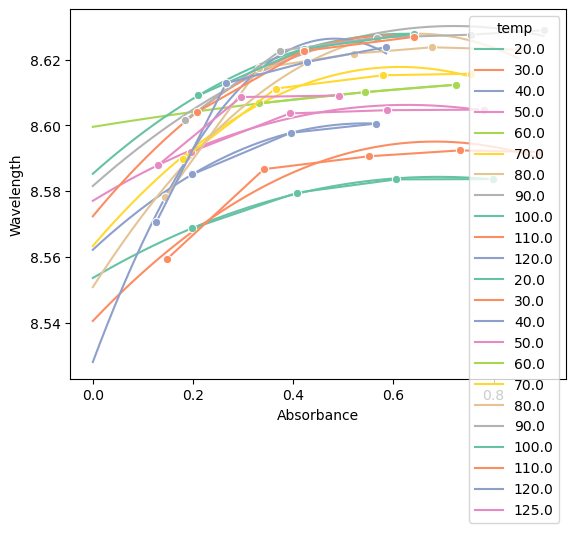

In [29]:
## To fit a polynomial to peak position data as a function of film thickenss(aka absorbance). 
## Aim is to get peak potision at zero absorbance

# define poltnomial function that auto scan through data in dataframe called "p"
def fit_polynomial_same_temp(df, x_col, y_col, temp_col, order):
    poly_data = pd.DataFrame()
    # Group the DataFrame by the temperature column and iterate over each group
    for temp, group in df.groupby(temp_col):
        
        # Extract the x and y data
        x_data = group[x_col]
        y_data = group[y_col]
        
        #print('xdata\n',x_data)
        #print('ydata\n',y_data)
        
        # Fit the polynomial
        coefficients = np.polyfit(x_data, y_data, order)

        # Create the polynomial function
        polynomial_func = np.poly1d(coefficients)
        
        # Print the polynomial function for this temperature
        #print(f"Polynomial function for {temp_col}={temp}:")
        #print(polynomial_func)
        #print("\n")
        
        # Generate x values for the plot
        x_plot = np.linspace(0, max(x_data), 400)

        # Compute y values for the plot
        y_plot = polynomial_func(x_plot)
        
        temp_data = pd.DataFrame({
            'x_plot': x_plot,
            'y_plot': y_plot,
            'temp': temp
        })
        poly_data = pd.concat([poly_data, temp_data])
        

    return poly_data

poly_data = fit_polynomial_same_temp(p, 'ab1', 'peak1', 'temp', 2)

#print(poly_data.loc[poly_data.temp<127])

#fig, axs = plt.subplots(2, 1, sharex=False, figsize=(4,6)) # I am making a 2 x 1 row x column grid
#fig.subplots_adjust(hspace=0.4)

poly_data_reset = poly_data.reset_index()
sns.lineplot(data=poly_data_reset.loc[poly_data_reset.temp<125], palette = "Set2",x='x_plot', y='y_plot',hue='temp')
sns.lineplot(data=p.loc[p.temp<127], palette = "Set2", x='ab1',y='peak1', marker='o', hue='temp')

# Set x and y axis limits
#plt.xlim(0, 0.27)
#plt.ylim(155, 156.5)

# Set x and y axis labels
plt.xlabel('Absorbance')
plt.ylabel('Wavelength')

# Show the plot
plt.show()



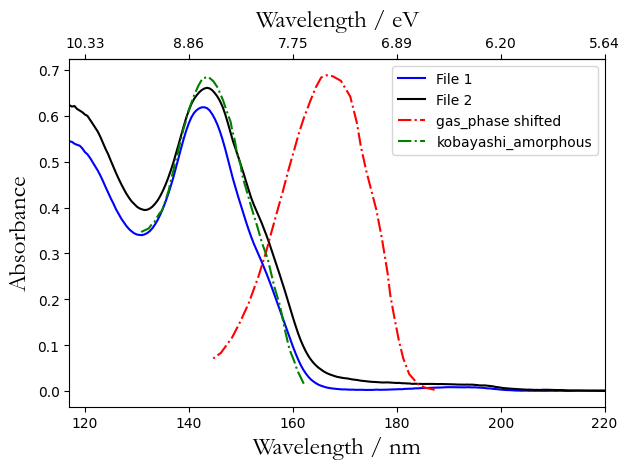

In [10]:
#plot selected spectra
Temp_to_plot = ('130K') #e.g., 100K, 020K  - alwyas three digits (no space!) You can plot two different temperatures
Dep_to_plot = ('4') #e.g., '2' just number
gas_shift = 0#23.5 # in nm
kobayashi_shift = 0 # in nm

File_name1 = ((Temp_to_plot)+'_dep'+(Dep_to_plot))

file1_to_plot = pd.read_csv('exports/'+File_name1+'.csv',header=[0])#,delimiter=r"\s+")

Temp_to_plot = ('140K') #e.g., 100K, 020K  - alwyas three digits (no space!) You can plot two different temperatures
Dep_to_plot = ('5') #e.g., '2' just number

File_name2 = ((Temp_to_plot)+'_dep'+(Dep_to_plot))

file2_to_plot = pd.read_csv('exports/'+File_name2+'.csv',header=[0])#,delimiter=r"\s+")


water_gas_phase = pd.read_csv('water_gas_phase.csv', header= [0])
water_kobayashi = pd.read_csv('water_kobayashi.csv', header= [0])

water_gas_phase['wavelength'] = 1239.8/water_gas_phase['x']
water_gas_phase['wavelength_shift'] = water_gas_phase['wavelength'] - gas_shift
water_gas_phase['absorbance'] = (water_gas_phase.iloc[:, 1]) / 7.5

water_kobayashi['wavelength'] = 1239.8/water_kobayashi['x']
water_kobayashi['wavelength_shift'] = water_kobayashi['wavelength'] - kobayashi_shift
water_kobayashi['absorbance'] = (water_kobayashi.iloc[:, 1]) / 4

# Function to prevent zero values in an array
def preventDivisionByZero(some_array):
    corrected_array = some_array.copy()
    for i, entry in enumerate(some_array):
        # If element is zero, set to some small value
        if abs(entry) < float_info.epsilon:
            corrected_array[i] = float_info.epsilon
    
    return corrected_array

# Converting wavelength (nm) to energy (eV)
def WLtoE(wl):
    # Prevent division by zero error
    wl = preventDivisionByZero(wl)

    # E = h*c/wl            
    h = constants.h         # Planck constant
    c = constants.c         # Speed of light
    J_eV = constants.e      # Joule-electronvolt relationship
    
    wl_nm = wl * 10**(-9)   # convert wl from nm to m
    E_J = (h*c) / wl_nm     # energy in units of J
    E_eV = E_J / J_eV       # energy in units of eV
    
    return E_eV  

# Converting energy (eV) to wavelength (nm)
def EtoWL(E):
    # Prevent division by zero error
    E = preventDivisionByZero(E)
    
    # Calculates the wavelength in nm
    return constants.h * constants.c / (constants.e * E) * 10**9

fig, ax1 = plt.subplots()

ax1.plot(file1_to_plot['wavelength'], file1_to_plot['absorbance_bk'],'b-', label='File 1')
ax1.plot(file2_to_plot['wavelength'], 1.00*file2_to_plot['absorbance_bk'],'k-', label='File 2')
ax1.plot(water_gas_phase['wavelength_shift'], water_gas_phase['absorbance'], 'r-.', label='gas_phase shifted')
ax1.plot(water_kobayashi['wavelength_shift'], water_kobayashi['absorbance'], 'g-.', label='kobayashi_amorphous')

ax1.set_ylabel('Absorbance',family="garamond", fontsize=18)
ax1.set_xlabel('Wavelength / nm',family="garamond", fontsize=18)
ax1.legend()
#plt.ylim(0,0.8)
ax1.set_xlim(117,220)
#ax1.axvline(x = 143,    
#           ymin = 0, # Bottom of the plot
#           ymax = 1) 
#ax1.axvline(x = 155,    
#           ymin = 0, # Bottom of the plot
#           ymax = 1) 

# Create the second x-axis on which the energy in eV will be displayed
ax2 = ax1.secondary_xaxis('top', functions=(WLtoE, EtoWL))
ax2.set_xlabel('Wavelength / eV',family="garamond", fontsize=18, labelpad=7)

# Get ticks from ax1 (wavelengths)
wl_ticks = ax1.get_xticks()
wl_ticks = preventDivisionByZero(wl_ticks)

# Based on the ticks from ax1 (wavelengths), calculate the corresponding energies in eV
E_ticks = WLtoE(wl_ticks)

# Set the ticks for ax2 (Energy)
ax2.set_xticks(E_ticks)

# Allow for two decimal places on ax2 (Energy)
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))


#ax1.legend()
#ax1.set_title((Temp_to_plot)+'_dep'+(Dep_to_plot),family="garamond", fontsize=22)
plt.tight_layout()
plt.show()

print(os.getcwd())
#os.chdir('..')
print(os.getcwd())

In [ ]:
#   plot spont and nonspont Gauss peak as function of absorbance
#----------------------------------------------------------------------
p = pd.DataFrame(data, columns=['temp','dep',
                                'ab1','peak1','sig1','ab1_er','peak1_er','sig1_er',
                                'ab2','peak2','sig2','ab2_er','peak2_er','sig2_er',
                                'ab3','peak3','sig3','ab3_er','peak3_er','sig3_er',
                                'ab4','peak4','sig4','ab4_er','peak4_er','sig4_er'])

fig, axs = plt.subplots(2, 1, sharex=False, figsize=(4,6)) # I am making a 2 x 1 row x column grid
fig.subplots_adjust(hspace=0.4)

#   144 nm peak
sns.lineplot(data=p.loc[p.temp>=125], x='dep',y='ab4', palette = "Set2", marker='o', hue='temp', ax=axs[0])
#   155 nm peak
sns.lineplot(data=p.loc[p.temp>=125], x='dep',y='ab1', palette = "Set2", marker='o', hue='temp', ax=axs[1])

axs[0].set_xlabel('deposition')
axs[0].set_title('Is peak 4 a contamination?')
#axs[1].set_title('Spont temps - 155 nm peak (>=125 K)')
#axs[1].set_xlabel('deposition')

plt.show()